# M2177.003100 Deep Learning Assignment #2<br> Part 2. Torchvision Object Detection Finetuning 

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Adapted by Hyeongrok Han from the IPython version of the PyTorch tutorial (https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html), PyTorch vision (https://github.com/pytorch/vision/tree/v0.3.0) in 2020



**For understanding of this work, please carefully look at given PPT file.**

In this notebook, you will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). <br> It contains 170 images with 345 instances of pedestrians, and you will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results. 
### Some helpful tutorials and references for assignment #2-2:
- [1] Pytorch tutorial [[link]](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] CNN Features off-the-shelf: an Astounding Baseline for Recognition [[link]](https://arxiv.org/abs/1403.6382) trains SVMs on features from ImageNet-pretrained ConvNet and reports several state of the art results.
<br>

First, you need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for Intersection over Union(IoU).<br>
! means that you can run a shell script in Jupyter notebook.

In [1]:
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 1.9 MB 2.5 MB/s eta 0:00:01
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-iipxmf3l
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=310164 sha256=84767fc5023db57dd2df4c3034fe9801af733b02596690a345352c2d6a609b8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ui54yvv/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools


## 1. Defining and loading datasets
The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allow for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that you require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, you query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


###  Let's write a dataset for the Penn-Fudan dataset.
First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip




In [2]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

--2020-10-17 08:36:04--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  7.65MB/s    in 8.2s    

2020-10-17 08:36:13 (6.28 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

  inflating: PennFudanPed/PNGImages/FudanPed00004.png  
  inflating: PennFudanPed/PNGImages/FudanPed00005.png  
  inflating: PennFudanPed/PNGImages/FudanPed00006.png  
  inflating: PennFudanPed/PNGImages/FudanPed00007.png  
  inflating: PennFudanPed/PNGImages/FudanPed00008.png  
  inflating: PennFudanPed/PNGImages/FudanPed00009.png  
  inflating: PennFudanPed/PNGImages/FudanPed00010.png  
  inflating: PennFudanPed/PNGImages/FudanPed00011.png  
  inflating: PennFudanPed/PNGImages/FudanPed00012.png  
  inflating: PennFudanPed/PNGImages/FudanPed00013.png  
  inflating: PennFudanPed/PNGImages/FudanPed00014.png  
  inflating: PennFudanPed/PNGImages/FudanPed00015.png  
  inflating: PennFudanPed/PNGImages/FudanPed00016.png  
  inflating: PennFudanPed/PNGImages/FudanPed00017.png  
  inflating: PennFudanPed/PNGImages/FudanPed00018.png  
  inflating: PennFudanPed/PNGImages/FudanPed00019.png  
  inflating: PennFudanPed/PNGImages/FudanPed00020.png  
  inflating: PennFudanPed/PNGImages/FudanPed0002

  inflating: PennFudanPed/PNGImages/PennPed00089.png  
  inflating: PennFudanPed/PNGImages/PennPed00090.png  
  inflating: PennFudanPed/PNGImages/PennPed00091.png  
  inflating: PennFudanPed/PNGImages/PennPed00092.png  
  inflating: PennFudanPed/PNGImages/PennPed00093.png  
  inflating: PennFudanPed/PNGImages/PennPed00094.png  
  inflating: PennFudanPed/PNGImages/PennPed00095.png  
  inflating: PennFudanPed/PNGImages/PennPed00096.png  
  inflating: PennFudanPed/readme.txt  


Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

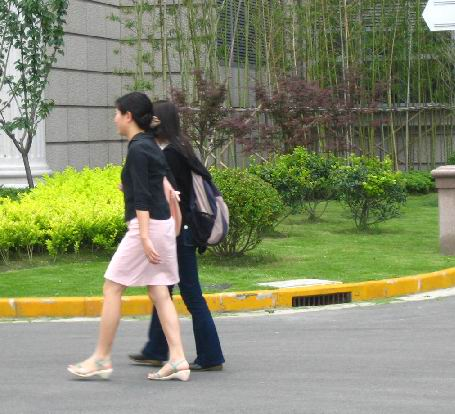

In [5]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00002.png')

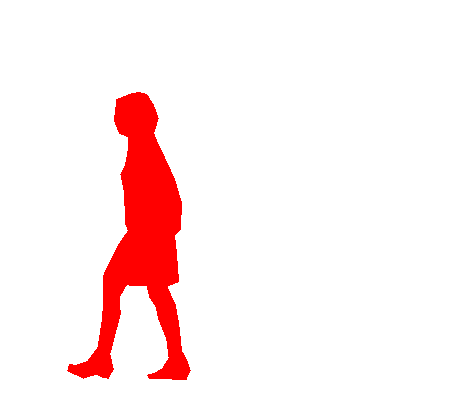

In [7]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00002_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

So each image has a corresponding segmentation mask, where each color corresponds to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [8]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that you haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [9]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F06AD6913A0>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

## 2. Defining your model
You will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.<br>
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

### An Instance segmentation model for PennFudan Dataset
In this notebook, you will fine-tune from a pre-trained model, given that our dataset is very small.

Here maybe you also want to compute the instance segmentation masks, so you will be using Mask R-CNN:





In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

This will make model be ready to be trained and evaluated on our custom dataset.

## 3. Training and evaluation functions

In `references/detection/,` you have a number of helper functions to simplify training and evaluating detection models.
Here, you will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [11]:
!git clone https://github.com/pytorch/vision.git
!cd vision && cp references/detection/utils.py ../ && cp references/detection/transforms.py ../ && cp references/detection/coco_eval.py ../ && cp references/detection/engine.py ../ && cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 10641 (delta 19), reused 24 (delta 12), pack-reused 10591
Receiving objects: 100% (10641/10641), 11.92 MiB | 4.40 MiB/s, done.
Resolving deltas: 100% (7392/7392), done.


Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that you have just copied:


In [12]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Putting everything together

You now have the dataset class, the models and the data transforms. Let's instantiate them

In [13]:
# use your dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now then, yoy should instantiate the model and the optimizer
### Things you should do:
- Get the model using our helper function
- Move model to the right device
- Construct an optimizer
- Construct a learning rate scheduer

In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

import torch.optim as optim
model = get_instance_segmentation_model(num_classes).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.99,)



##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/jaekyungcho/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


And now let's train the model for 10 epochs, evaluating at the end of every epoch. <br>
If you want to learn more about Average precision(AP) and Average Recall(AR), please note following websites. <br>
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173,<br> https://bskyvision.com/465 

In [15]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/home/jaekyungcho/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/jaekyungcho/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/60]  eta: 0:00:57  lr: 0.000018  loss: 3.6496 (3.6496)  loss_classifier: 0.7385 (0.7385)  loss_box_reg: 0.2383 (0.2383)  loss_mask: 2.6621 (2.6621)  loss_objectness: 0.0070 (0.0070)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 0.9647  data: 0.1778  max mem: 2300
Epoch: [0]  [10/60]  eta: 0:00:18  lr: 0.000187  loss: 1.1002 (1.7935)  loss_classifier: 0.2264 (0.3551)  loss_box_reg: 0.2380 (0.2388)  loss_mask: 0.6197 (1.1624)  loss_objectness: 0.0199 (0.0251)  loss_rpn_box_reg: 0.0055 (0.0121)  time: 0.3672  data: 0.0204  max mem: 3024
Epoch: [0]  [20/60]  eta: 0:00:13  lr: 0.000357  loss: 0.8447 (1.2906)  loss_classifier: 0.1762 (0.2407)  loss_box_reg: 0.1999 (0.2035)  loss_mask: 0.4210 (0.8150)  loss_objectness: 0.0118 (0.0180)  loss_rpn_box_reg: 0.0092 (0.0134)  time: 0.3029  data: 0.0049  max mem: 3025
Epoch: [0]  [30/60]  eta: 0:00:09  lr: 0.000526  loss: 0.6148 (1.0688)  loss_classifier: 0.0883 (0.1935)  loss_box_reg: 0.1586 (0.1908)  loss_mask: 0.3551 (0.6557)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:00:27  lr: 0.000980  loss: 0.2907 (0.2907)  loss_classifier: 0.0493 (0.0493)  loss_box_reg: 0.0674 (0.0674)  loss_mask: 0.1648 (0.1648)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 0.4622  data: 0.1494  max mem: 3762
Epoch: [2]  [10/60]  eta: 0:00:16  lr: 0.000980  loss: 0.4372 (0.4660)  loss_classifier: 0.0662 (0.0727)  loss_box_reg: 0.1052 (0.1215)  loss_mask: 0.2261 (0.2530)  loss_objectness: 0.0058 (0.0072)  loss_rpn_box_reg: 0.0070 (0.0115)  time: 0.3226  data: 0.0185  max mem: 3762
Epoch: [2]  [20/60]  eta: 0:00:12  lr: 0.000980  loss: 0.4372 (0.4467)  loss_classifier: 0.0539 (0.0685)  loss_box_reg: 0.0999 (0.1122)  loss_mask: 0.2176 (0.2491)  loss_objectness: 0.0057 (0.0059)  loss_rpn_box_reg: 0.0072 (0.0110)  time: 0.2990  data: 0.0055  max mem: 3762
Epoch: [2]  [30/60]  eta: 0:00:09  lr: 0.000980  loss: 0.5349 (0.5371)  loss_classifier: 0.0767 (0.0975)  loss_box_reg: 0.1434 (0.1417)  loss_mask: 0.2650 (0.2711)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:00:23  lr: 0.000961  loss: 0.2348 (0.2348)  loss_classifier: 0.0215 (0.0215)  loss_box_reg: 0.0476 (0.0476)  loss_mask: 0.1565 (0.1565)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 0.3947  data: 0.1355  max mem: 3762
Epoch: [4]  [10/60]  eta: 0:00:16  lr: 0.000961  loss: 0.4919 (0.4664)  loss_classifier: 0.0770 (0.0744)  loss_box_reg: 0.1571 (0.1540)  loss_mask: 0.1993 (0.2038)  loss_objectness: 0.0078 (0.0197)  loss_rpn_box_reg: 0.0133 (0.0146)  time: 0.3280  data: 0.0173  max mem: 3762
Epoch: [4]  [20/60]  eta: 0:00:12  lr: 0.000961  loss: 0.4711 (0.4666)  loss_classifier: 0.0724 (0.0722)  loss_box_reg: 0.1377 (0.1429)  loss_mask: 0.2346 (0.2235)  loss_objectness: 0.0089 (0.0153)  loss_rpn_box_reg: 0.0093 (0.0126)  time: 0.3043  data: 0.0054  max mem: 3762
Epoch: [4]  [30/60]  eta: 0:00:09  lr: 0.000961  loss: 0.4542 (0.4834)  loss_classifier: 0.0743 (0.0763)  loss_box_reg: 0.1178 (0.1449)  loss_mask: 0.2194 (0.2269)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:00:31  lr: 0.000941  loss: 0.4406 (0.4406)  loss_classifier: 0.0707 (0.0707)  loss_box_reg: 0.1504 (0.1504)  loss_mask: 0.2086 (0.2086)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0105 (0.0105)  time: 0.5171  data: 0.1508  max mem: 3762
Epoch: [6]  [10/60]  eta: 0:00:17  lr: 0.000941  loss: 0.3203 (0.3272)  loss_classifier: 0.0555 (0.0548)  loss_box_reg: 0.0941 (0.1014)  loss_mask: 0.1462 (0.1609)  loss_objectness: 0.0025 (0.0026)  loss_rpn_box_reg: 0.0077 (0.0075)  time: 0.3461  data: 0.0186  max mem: 3762
Epoch: [6]  [20/60]  eta: 0:00:13  lr: 0.000941  loss: 0.3002 (0.3502)  loss_classifier: 0.0503 (0.0553)  loss_box_reg: 0.0922 (0.1095)  loss_mask: 0.1616 (0.1741)  loss_objectness: 0.0021 (0.0025)  loss_rpn_box_reg: 0.0078 (0.0088)  time: 0.3298  data: 0.0054  max mem: 3762
Epoch: [6]  [30/60]  eta: 0:00:09  lr: 0.000941  loss: 0.3398 (0.3548)  loss_classifier: 0.0520 (0.0560)  loss_box_reg: 0.0878 (0.1087)  loss_mask: 0.1710 (0.1776)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:00:33  lr: 0.000923  loss: 0.3537 (0.3537)  loss_classifier: 0.0369 (0.0369)  loss_box_reg: 0.0823 (0.0823)  loss_mask: 0.2243 (0.2243)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 0.5532  data: 0.2601  max mem: 3762
Epoch: [8]  [10/60]  eta: 0:00:17  lr: 0.000923  loss: 0.3537 (0.3548)  loss_classifier: 0.0464 (0.0570)  loss_box_reg: 0.0842 (0.1043)  loss_mask: 0.1566 (0.1774)  loss_objectness: 0.0008 (0.0056)  loss_rpn_box_reg: 0.0072 (0.0107)  time: 0.3400  data: 0.0270  max mem: 3762
Epoch: [8]  [20/60]  eta: 0:00:13  lr: 0.000923  loss: 0.3348 (0.3547)  loss_classifier: 0.0464 (0.0508)  loss_box_reg: 0.0854 (0.1060)  loss_mask: 0.1658 (0.1796)  loss_objectness: 0.0011 (0.0051)  loss_rpn_box_reg: 0.0077 (0.0132)  time: 0.3158  data: 0.0044  max mem: 3762
Epoch: [8]  [30/60]  eta: 0:00:09  lr: 0.000923  loss: 0.3242 (0.3507)  loss_classifier: 0.0492 (0.0519)  loss_box_reg: 0.1111 (0.1097)  loss_mask: 0.1528 (0.1726)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

Let's inspect the image and the predicted segmentation masks.

For that, you need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that you have it in [C, H, W] format.

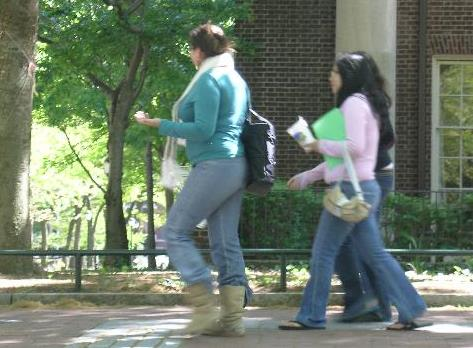

In [21]:
img, _ = dataset_test[2]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as [N, 1, H, W], where N is the number of predictions, and are probability maps between 0-1.

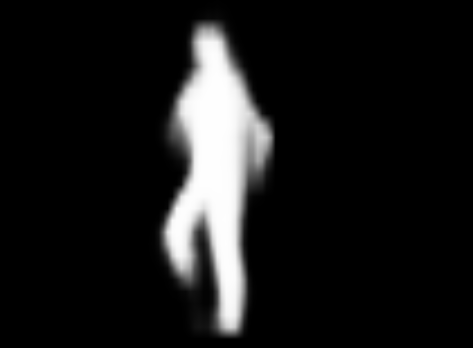

In [22]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented.<br><br>
You can write in Korean <br><br>
_Tell us here_

## 답변

따로 크게 추가한 것은 없다. 기존의 mask-RCNN 모델은 coco dataset의 output classes 개수에 맞추어져 있기 때문에 이를 사람인지 아닌지만 segmentation 하도록 변환해 준 것이다.

이때 사용한 optimizer 로는 Adam을 사용하였고, learning rate scheduler로는 Exponential learning rate decaying을 사용하여 단순히 매 epoch 마다 0.99가 곱해진 learning rate을 사용하도록 하였다.
